<a href="https://colab.research.google.com/github/MatteoRobbiati/notebooks/blob/main/QTI-hands-on-qibo/QTI_hands_on_qibo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#QTI TH - hands on qibo

### Download `qibo`

In [1]:
!pip install qibo
#!pip install qibojit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.8/225.8 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 KB 25.7 MB/s eta 0:00:00


### Getting started with qibo

Let's start importing `qibo` and the modules required for building our first circuit.
We set the default `numpy` backend for this tutorial.


In [2]:
# we import the qibo library
import qibo
from qibo import gates
from qibo.models import Circuit

import numpy as np
# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', font_scale=1.6)

# we use the numpy backend for doing simulation
qibo.set_backend('numpy')

[Qibo 0.1.10|INFO|2023-01-11 08:08:27]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


After this, we can start to do quantum circuit simulation using `qibo`.

## Some general feature

In [3]:
nqubits = 3
layers = 2

# initialize the circuit
c = Circuit(nqubits)

# adding some rotations 
for q in range(nqubits):
  c.add(gates.H(q))
  for l in range(layers):
    c.add(gates.RY(q=q, theta=0))
    c.add(gates.RZ(q=q, theta=0))
# adding a CNOT and a some measurements
c.add(gates.CNOT(q0=0, q1=nqubits-1))
c.add(gates.M(i) for i in range(nqubits))

In [4]:
print(c.draw())

q0: ─H─RY─RZ─RY─RZ─o─M─
q1: ─H─RY─RZ─RY─RZ─|─M─
q2: ─H─RY─RZ─RY─RZ─X─M─


In [5]:
# summary
print(c.summary())

Circuit depth = 7
Total number of gates = 19
Number of qubits = 3
Most common gates:
ry: 6
rz: 6
h: 3
measure: 3
cx: 1


We can have access to OpenQASM transpilation of the code! This is the "Assembly version" for quantum computation and can be useful because it is a general language, perfectly adaptable to other frameworks (Qiskit, qsim, etc.)

In [6]:
# to Quantum Assembly Language
print(c.to_qasm())

// Generated by QIBO 0.1.10
OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg register0[1];
creg register1[1];
creg register2[1];
h q[0];
ry(0) q[0];
rz(0) q[0];
ry(0) q[0];
rz(0) q[0];
h q[1];
ry(0) q[1];
rz(0) q[1];
ry(0) q[1];
rz(0) q[1];
h q[2];
ry(0) q[2];
rz(0) q[2];
ry(0) q[2];
rz(0) q[2];
cx q[0],q[2];
measure q[0] -> register0[0];
measure q[1] -> register1[0];
measure q[2] -> register2[0];


In [7]:
# extracting information about parametetrized gates
first_parametrized_gate = c.parametrized_gates[0]

print("Gate object and memory address: ", first_parametrized_gate)
print("Gate name: ", first_parametrized_gate.name)
print("Number of variational parameters: ", first_parametrized_gate.nparams)

Gate object and memory address:  <qibo.gates.gates.RY object at 0x7fdc2fec96a0>
Gate name:  ry
Number of variational parameters:  1


In [8]:
# and their parameters
nparams = len(c.get_parameters())
print(nparams, c.get_parameters())

12 [(0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,)]


In [9]:
# inject a new set of parameters in the circuit

# generate the new set of params
test_params = np.random.randn(nparams)
# set them into the circuit
c.set_parameters(test_params)
# read circuit's parameters again
print(c.get_parameters())

[(0.7944010380296654,), (0.7318927281822513,), (0.34727787258030834,), (0.9152238543709214,), (-0.662857197539169,), (-0.9765205361335785,), (0.7449184327405478,), (1.4959397743150282,), (0.3306174730538961,), (-0.7102242476944309,), (-1.647901391882749,), (1.8646132943233913,)]


## State vector simulation

 
In quantum computing the state $| \psi \rangle $ of a system
of $n$ qubits is represented by a vector of $2^n$ complex probability amplitudes in the computational basis. 

Every action performed on a quantum state can be represented via matrix multiplication. In particular, if we consider a gate $G$ targeting $n_{tar}$ qubits, it might be represented as a $n_{tar} \times n_{tar}$ matrix.  This can be simulated adopting the **state vector simulation** approach. It solves:

$$ \psi'(\tau, q) = \sum_{\tau'} G(\tau, \tau')\psi(\tau', q), $$

where $\tau$ and $q$ denote bitstrings of length $n_{tar}$ and $n − n_{tar}$ respectively and the sum runs over
all possibile bitstrings $\tau$ of length $n_{tar}$. 

In [10]:
def visualize_states(counter):
 
  fig, ax = plt.subplots()

  ax.set_title('State visualization')
  ax.set_xlabel('States')
  ax.set_ylabel('#')

  for state in counter:
    ax.scatter(state, counter[state], color='purple', alpha=0.5, s=150)
    ax.vlines(state, 0, counter[state] - 12, color='black', ls='-', lw=1.2)


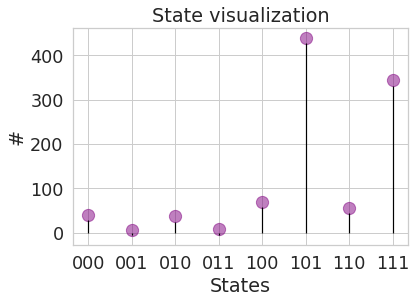

In [11]:
frequencies = c(nshots=1000).frequencies(binary=True)

visualize_states(frequencies)


### Simulating the superposition

Now we can build up a simple circuit composed of one qubit and an Hadamard gate. This gate is such that, if applied to one of the fundamental states, it returns a superposed state:

$$ H|0\rangle  = \frac{1}{\sqrt{2}}\bigl(|0\rangle + |1\rangle \bigr). $$
$$ H|1\rangle  = \frac{1}{\sqrt{2}}\bigl(|0\rangle - |1\rangle \bigr). $$

At the end of the circuit we put a measurement gate, in order to be able to project the final state on the $z$ direction and to perform a simple measurement operation.

Using a circuit diagram:

<center><img src="https://github.com/MatteoRobbiati/notebooks/blob/main/QTI-hands-on-qibo/figures/superposition.png?raw=true" alt="drawing" width="400"/></center>

In [12]:
# set the number of qubits of the circuit
nqubits = 1

In [13]:
# initialize the circuit 
c_1q = Circuit(nqubits=nqubits)

# if initial_state is not provided, default is |0>

# add gates
# an Hadamard gate and a measurement
c_1q.add(gates.H(q=0))
c_1q.add(gates.M(0))

# draw circuit
print("Circuit's object: ", c_1q)
print(c_1q.draw())

Circuit's object:  <qibo.models.circuit.Circuit object at 0x7fdc1f169700>
q0: ─H─M─


### Simulating the execution of the circuit

Now we can execute the circuit $N_{shots}=1000$ times, and use the simulation tool for getting the results.


In [18]:
# executing nshot times the circuit we get the simulated final state
simulated_final_state = c_1q(nshots=1000)

print(simulated_final_state)

(0.70711+0j)|0> + (0.70711+0j)|1>


With this execution we simulate the final state obtained applying an Hadamard gate on an initial $| 0 \rangle$ state.
Thanks to state vector simulation, the results are exact. 

#### Printing probabilities

We can se the exact results, e.g., by printing probabilities associated to the fundamental states in the target system.


In [23]:
# calculating probabilities
probabilities = simulated_final_state.probabilities(qubits=[0])

# showing the two probabilities
print(probabilities)

[0.5 0.5]


## What if we want to simulate a real circuit behaviour?
A real circuit doesn't return exact values, but some statistical results. This is due to the real randomness of a quantum system. 
In qibo we can use the `frequencies` method for visualizing these realistic results. It provides us with a counter object, containing the simulation of $N_{shots}$ collapsed states. When we call the method, we can set the `binary=True` option; thanks this the counter keys will be the names of the states (such as `'00', '01', '11'` etc.)



In [25]:
freq = simulated_final_state.frequencies(binary=True)
print(freq)

Counter({'1': 515, '0': 485})


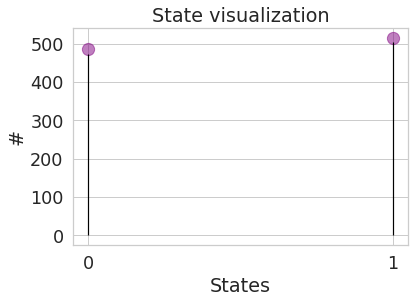

In [26]:
visualize_states(freq)

This feature is useful if we want to treat the simulated object like a real circuit. Let's try to see the differences between the exact calculations and the real circuit simulation:

In [42]:
# let's try to repeat the experiment 2 times
# one with nshots=100, one with nshots=10000

# simulate the final states
final_state_10k = c_1q(nshots=10000)
final_state_100 = c_1q(nshots=100)

# calculate the probabilities
prob_10k = final_state_10k.probabilities(qubits=[0])
prob_100 = final_state_100.probabilities(qubits=[0])

# simulate the frequencies
freq_10k = final_state_10k.frequencies(binary=True)
freq_100 = final_state_100.frequencies(binary=True)

# I want to calculate real probabilities from frequencies
prob_real_10k = []
prob_real_100 = []

# Normalizing with respect to nshots
for state1, state2 in zip(freq_10k, freq_100):
  prob_real_10k.append(freq_10k[state1]/10000)
  prob_real_100.append(freq_100[state2]/100)

# showing the results
print('Exact prob 10k shots: ', prob_10k)
print('Exact prob 100 shots: ', prob_100)
print('Simulated real prob 10k shots: ', prob_real_10k)
print('Simulated real prob 100 shots: ', prob_real_100)

Exact prob 10k shots:  [0.5 0.5]
Exact prob 100 shots:  [0.5 0.5]
Simulated real prob 10k shots:  [0.4925, 0.5075]
Simulated real prob 100 shots:  [0.48, 0.52]


### Measurements in qibo

In qibo we provide two different ways for performing measurements:

- **without collapse**: the quantum state is simulated, then we sample the measurements output using a random generator starting by the quantum state, without making him collapse. This is the method used in the previous section and the suggested one if you **don't need to have collapsed state into your circuit!**
- **with collapse**: the state vector collapse into one of the accessible states following the theoretical probabilies.

In [44]:
# initialize a new realistic circuit
c_real = Circuit(1)

# add gates
c_real.add(gates.H(q=0))
c_real.add(gates.M(0, collapse=True))

results = c_real(nshots=5)
results

[array([1.+0.j, 0.+0.j]),
 array([0.+0.j, 1.+0.j]),
 array([0.+0.j, 1.+0.j]),
 array([0.+0.j, 1.+0.j]),
 array([1.+0.j, 0.+0.j])]

Each measurement here returns an array object in $C^2$ containing the measured (collapsed) state.


## Building entanglement

Let's consider now a two qubit system. We can use two-qubits gates for building entanglement. This means that the total final state of the system is such that the output obtained measuring qubit 1 affects the result on the qubit 2. For building an entangled Bell's state we can use for example an Hadmard gate and a c-NOT gate.

Using a circuit diagram, we are going to do the following:
<center><img src="https://github.com/MatteoRobbiati/notebooks/blob/main/QTI-hands-on-qibo/figures/entanglement.png?raw=true" alt="drawing" width="400"/></center>

In [46]:
# we need a two qubits system now 
nqubits = 2

# new circuit
c_ent = Circuit(nqubits)

# H and than a c-NOT gate
c_ent.add(gates.H(q=0))
c_ent.add(gates.CNOT(q0=0, q1=1))
c_ent.add(gates.M(0,1))

MeasurementResult(qubits=(0, 1), nshots=0)

In [47]:
# simulating and printing the final state 
final_state_ent = c_ent(nshots=1000)
print(final_state_ent)

(0.70711+0j)|00> + (0.70711+0j)|11>


In [48]:
# simulating and printing the real behaviour of a quantum circuit using frequencies
freq = final_state_ent.frequencies(binary=True)

freq

Counter({'00': 503, '11': 497})

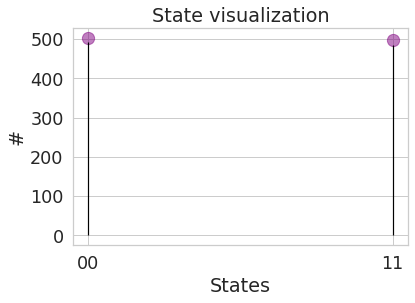

In [49]:
# visualizing the states
visualize_states(freq)

## How can we build the others Bell's state?